In [1]:
test_run = True
import os
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/CIDDS-001/train_set_full.csv"
)
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/CIDDS-001/test_set.csv"
)

tuning_metric = "f1"  # f1 or accuracy

if test_run:
    use_sample = True
    train_frac = 0.01
    with_storage = False
    trials = 10
else:
    os.makedirs("optuna_storage", exist_ok=True)
    storage_path = "sqlite:///optuna_storage/dbscan_study.db"
    use_sample = False
    train_frac = 1
    with_storage = True
    trials = 100

# Autoencoder Setup

In [2]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


def extract_encoded_features(X_data, autoencoder, device, batch_size=256):
    # Convert to PyTorch tensor and prepare data loader
    X_tensor = torch.FloatTensor(X_data)
    X_dataset = TensorDataset(X_tensor)
    X_loader = DataLoader(X_dataset, batch_size=batch_size)

    # Extract encoded features
    X_encoded = []
    with torch.no_grad():
        for data in X_loader:
            data_x = data[0].to(device)
            encoded = autoencoder.encode(data_x)
            X_encoded.append(encoded.cpu().numpy())

    return np.vstack(X_encoded)

In [3]:
from autoencoder import BatchNormAutoencoder

existing_model_path = "saved_models/config 4/autoencoder_Model_1_hidden[14, 12]_latent10_lr0.001_bs256_optrmsprop_actLeakyReLU_slp0.2_wd0.pth"

existing_model_architecture = {
    "input_dim": 16,
    "hidden_dims": [14, 12],
    "latent_dim": 10,
    "activation_type": "LeakyReLU",
    "negative_slope": 0.2,
    "output_activation_type": "Sigmoid",
}

autoencoder = BatchNormAutoencoder(
    input_dim=existing_model_architecture["input_dim"],
    hidden_dims=existing_model_architecture["hidden_dims"],
    latent_dim=existing_model_architecture["latent_dim"],
    activation_type=existing_model_architecture["activation_type"],
    negative_slope=existing_model_architecture["negative_slope"],
    output_activation_type=existing_model_architecture["output_activation_type"],
).to(device)

# Load best model
checkpoint = torch.load(existing_model_path)
autoencoder.load_state_dict(checkpoint["model_state_dict"])

autoencoder.eval()

BatchNormAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=14, bias=True)
    (1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=14, out_features=12, bias=True)
    (4): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=12, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=12, bias=True)
    (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=12, out_features=14, bias=True)
    (4): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=14, out_features=16, bias=True)
    (7): Sigmoid()
  )
)

# Dataset setup

Import train dataset

In [4]:
import pandas as pd

train_dataset = pd.read_csv(train_set_path)

if use_sample:
    train_dataset = train_dataset.sample(frac=train_frac, random_state=42)

X_train = train_dataset.drop(columns=["attack_binary", "attack_categorical"]).values
y_train = train_dataset["attack_binary"].values

print(f"train set count: {train_dataset.shape[0]:,}")
print(f"unique values: {train_dataset['attack_categorical'].unique()}")
train_dataset.head(3)

train set count: 1,800
unique values: ['benign']


,duration,packets,bytes,flows,tcp_urg,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,attack_id,proto_ICMP,proto_IGMP,proto_TCP,proto_UDP,attack_binary,attack_categorical
123137,0.001965,0.000032,0.000007,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,1,benign
130504,0.000483,0.000027,0.000005,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,1,benign
31166,0.001782,0.000070,0.000011,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.166667,0.0,0.0,0.0,1.0,0.0,1,benign


import test set

In [5]:
test_dataset = pd.read_csv(test_set_path)
print(f"test set count: {test_dataset.shape[0]:,}")
print(f"unique values: {test_dataset['attack_categorical'].value_counts()}")
test_dataset.head(3)

test set count: 20,000
unique values: attack_categorical
benign        11226
dos            5564
portScan       1730
bruteForce      804
pingScan        676
Name: count, dtype: int64


,duration,packets,bytes,flows,tcp_urg,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,attack_id,proto_ICMP,proto_IGMP,proto_TCP,proto_UDP,attack_binary,attack_categorical
0,0.000640,0.000021,0.000002,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,1.0,0.0,1,benign
1,0.011037,0.000011,0.000001,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,1,benign
2,0.011396,0.000091,0.000006,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,1,benign


splitting into validation and test set

In [6]:
from sklearn.model_selection import train_test_split

test_df, val_df = train_test_split(
    test_dataset,
    test_size=0.5,
    random_state=42,
    stratify=test_dataset["attack_categorical"],
)

test set

In [7]:
# Splitting into X and y
X_test = test_df.drop(columns=["attack_binary", "attack_categorical"]).values
y_test = test_df["attack_binary"].values
y_test_class = test_df["attack_categorical"].values

print(f"test set count: {test_df.shape[0]:,}")
print(f"unique values: {test_df['attack_categorical'].value_counts()}")
test_df.head(3)

test set count: 10,000
unique values: attack_categorical
benign        5613
dos           2782
portScan       865
bruteForce     402
pingScan       338
Name: count, dtype: int64


,duration,packets,bytes,flows,tcp_urg,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,attack_id,proto_ICMP,proto_IGMP,proto_TCP,proto_UDP,attack_binary,attack_categorical
12406,0.000829,0.000075,4.657671e-06,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,66.0,0.0,0.0,1.0,0.0,-1,pingScan
15620,0.002278,0.000016,4.326256e-07,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,53.0,0.0,0.0,1.0,0.0,-1,dos
17951,0.000202,0.000021,1.103394e-06,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,1.0,0.0,-1,bruteForce


validation set

In [8]:
# Splitting into X and y
X_val = val_df.drop(columns=["attack_binary", "attack_categorical"]).values
y_val = val_df["attack_binary"].values
y_val_class = val_df["attack_categorical"].values

print(f"test set count: {val_df.shape[0]:,}")
print(f"unique values: {val_df['attack_categorical'].value_counts()}")
val_df.head(3)

test set count: 10,000
unique values: attack_categorical
benign        5613
dos           2782
portScan       865
bruteForce     402
pingScan       338
Name: count, dtype: int64


,duration,packets,bytes,flows,tcp_urg,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,attack_id,proto_ICMP,proto_IGMP,proto_TCP,proto_UDP,attack_binary,attack_categorical
9482,0.005580,0.000054,3.099822e-06,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,benign
12490,0.000561,0.000016,4.564398e-07,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,60.0,0.0,0.0,1.0,0.0,-1,dos
18001,0.002043,0.000048,1.697559e-05,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,53.0,0.0,0.0,1.0,0.0,-1,dos


Applying  SMOTE to validation set

In [9]:
from imblearn.over_sampling import SMOTE
import numpy as np

# First, display the original distribution
print("Before SMOTE:")
print(f"Val set count: {X_val.shape[0]:,}")
before_counts = pd.Series(y_val_class).value_counts()
print(before_counts)

# Apply SMOTE to training data using class labels
sampling_strategy = {
    "dos": 4000,
    "portScan": 1500,
    "bruteForce": 1500,
    "pingScan": 500,
}
smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy=sampling_strategy)
X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val_class)

# Display the distribution after SMOTE
print("\nAfter SMOTE:")
print(f"Val set count: {X_val_resampled.shape[0]:,}")
after_counts = pd.Series(y_val_resampled).value_counts()
print(after_counts)

# If you need binary labels for further processing, convert back
y_val_resampled = np.where(y_val_resampled == "benign", 1, -1)

Before SMOTE:
Val set count: 10,000
benign        5613
dos           2782
portScan       865
bruteForce     402
pingScan       338
Name: count, dtype: int64

After SMOTE:
Val set count: 13,113
benign        5613
dos           4000
portScan      1500
bruteForce    1500
pingScan       500
Name: count, dtype: int64


# Hyperparameter tuning

objective function, maximizing the f1-score

In [10]:
X_train_encoded = extract_encoded_features(X_train, autoencoder, device)
X_val_encoded = extract_encoded_features(X_val_resampled, autoencoder, device)
X_test_encoded = extract_encoded_features(X_test, autoencoder, device)
print(X_train_encoded.shape)
print(X_val_encoded.shape)
print(X_test_encoded.shape)

(1800, 10)
(13113, 10)
(10000, 10)


In [11]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import optuna


def objective(trial):
    nu = trial.suggest_float("nu", 0.01, 0.5)
    gamma = trial.suggest_float("gamma", 0.01, 1.0)

    ocsvm = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)
    ocsvm.fit(X_train_encoded)

    y_pred_val = ocsvm.predict(X_val_encoded)
    y_pred_test = ocsvm.predict(X_test_encoded)

    acc_val = accuracy_score(y_val_resampled, y_pred_val)
    f1_val = f1_score(y_val_resampled, y_pred_val, pos_label=-1)
    precision_val = precision_score(y_val_resampled, y_pred_val, pos_label=-1)
    recall_val = recall_score(y_val_resampled, y_pred_val, pos_label=-1)
    print("Validation Results:")
    print(
        {
            "accuracy": f"{acc_val * 100:.2f}",
            "f1": f"{f1_val * 100:.2f}",
            "precision": f"{precision_val * 100:.2f}",
            "recall": f"{recall_val * 100:.2f}",
        }
    )

    print("\nTest Results:")
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, pos_label=-1)
    precision_test = precision_score(y_test, y_pred_test, pos_label=-1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=-1)
    print(
        {
            "accuracy": f"{acc_test * 100:.2f}",
            "f1": f"{f1_test * 100:.2f}",
            "precision": f"{precision_test * 100:.2f}",
            "recall": f"{recall_test * 100:.2f}",
        }
    )

    if tuning_metric == "f1":
        return f1_val
    elif tuning_metric == "accuracy":
        return acc_val
    else:
        raise ValueError("Invalid tuning metric")


if with_storage:
    storage_path = "sqlite:////work/base_ocsvm_study.db"
    study = optuna.create_study(
        direction="maximize",
        storage=storage_path,
        study_name="base_ocsvm_study",
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=trials)
else:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=trials)


print(f"Best score: {study.best_value:.3f}")
print(f"Best parameters: {study.best_params}")

/home/jbct/Projects/thesis/db-ocsvm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-23 19:20:18,828] A new study created in memory with name: no-name-18f24159-fce6-4bc7-9dac-f2ee981cc57e
[I 2025-03-23 19:20:19,425] Trial 0 finished with value: 0.9214891264283082 and parameters: {'nu': 0.23308296847547447, 'gamma': 0.7709984843700711}. Best is trial 0 with value: 0.9214891264283082.


Validation Results:
{'accuracy': '90.25', 'f1': '92.15', 'precision': '85.44', 'recall': '100.00'}

Test Results:
{'accuracy': '87.32', 'f1': '87.37', 'precision': '77.58', 'recall': '100.00'}


[I 2025-03-23 19:20:20,415] Trial 1 finished with value: 0.8682062858135093 and parameters: {'nu': 0.4093648974453415, 'gamma': 0.49764511778376525}. Best is trial 0 with value: 0.9214891264283082.


Validation Results:
{'accuracy': '82.64', 'f1': '86.82', 'precision': '76.71', 'recall': '100.00'}

Test Results:
{'accuracy': '77.49', 'f1': '79.58', 'precision': '66.09', 'recall': '100.00'}


[I 2025-03-23 19:20:20,990] Trial 2 finished with value: 0.9145226191927813 and parameters: {'nu': 0.2539774772438258, 'gamma': 0.026385921968568725}. Best is trial 0 with value: 0.9214891264283082.


Validation Results:
{'accuracy': '89.31', 'f1': '91.45', 'precision': '84.25', 'recall': '100.00'}

Test Results:
{'accuracy': '85.88', 'f1': '86.14', 'precision': '75.65', 'recall': '100.00'}


[I 2025-03-23 19:20:21,558] Trial 3 finished with value: 0.9167023162011856 and parameters: {'nu': 0.2471992761829332, 'gamma': 0.2876910171130869}. Best is trial 0 with value: 0.9214891264283082.


Validation Results:
{'accuracy': '89.61', 'f1': '91.67', 'precision': '84.62', 'recall': '100.00'}

Test Results:
{'accuracy': '86.52', 'f1': '86.68', 'precision': '76.50', 'recall': '100.00'}


[I 2025-03-23 19:20:22,476] Trial 4 finished with value: 0.8712825278810409 and parameters: {'nu': 0.39039433572043075, 'gamma': 0.2714491615092272}. Best is trial 0 with value: 0.9214891264283082.


Validation Results:
{'accuracy': '83.10', 'f1': '87.13', 'precision': '77.19', 'recall': '100.00'}

Test Results:
{'accuracy': '78.27', 'f1': '80.15', 'precision': '66.88', 'recall': '100.00'}


[I 2025-03-23 19:20:23,664] Trial 5 finished with value: 0.8463100880162492 and parameters: {'nu': 0.48574868422338974, 'gamma': 0.45895469313610987}. Best is trial 0 with value: 0.9214891264283082.


Validation Results:
{'accuracy': '79.23', 'f1': '84.63', 'precision': '73.36', 'recall': '100.00'}

Test Results:
{'accuracy': '73.32', 'f1': '76.68', 'precision': '62.18', 'recall': '100.00'}


[I 2025-03-23 19:20:24,050] Trial 6 finished with value: 0.9455966714997163 and parameters: {'nu': 0.1635540966649677, 'gamma': 0.023022492412508706}. Best is trial 6 with value: 0.9455966714997163.


Validation Results:
{'accuracy': '93.42', 'f1': '94.56', 'precision': '89.68', 'recall': '100.00'}

Test Results:
{'accuracy': '91.04', 'f1': '90.73', 'precision': '83.04', 'recall': '100.00'}


[I 2025-03-23 19:20:24,995] Trial 7 finished with value: 0.8619203585588692 and parameters: {'nu': 0.42870468877689527, 'gamma': 0.06591018746011203}. Best is trial 6 with value: 0.9455966714997163.
[I 2025-03-23 19:20:25,178] Trial 8 finished with value: 0.9746588693957114 and parameters: {'nu': 0.06984053583856417, 'gamma': 0.39783127661205436}. Best is trial 8 with value: 0.9746588693957114.


Validation Results:
{'accuracy': '81.67', 'f1': '86.19', 'precision': '75.73', 'recall': '100.00'}

Test Results:
{'accuracy': '76.31', 'f1': '78.74', 'precision': '64.93', 'recall': '100.00'}
Validation Results:
{'accuracy': '97.03', 'f1': '97.47', 'precision': '95.06', 'recall': '100.00'}

Test Results:
{'accuracy': '95.94', 'f1': '95.58', 'precision': '91.53', 'recall': '100.00'}


[I 2025-03-23 19:20:26,062] Trial 9 finished with value: 0.8775008775008775 and parameters: {'nu': 0.37815061602743577, 'gamma': 0.7357721736386903}. Best is trial 8 with value: 0.9746588693957114.


Validation Results:
{'accuracy': '84.03', 'f1': '87.75', 'precision': '78.17', 'recall': '100.00'}

Test Results:
{'accuracy': '79.37', 'f1': '80.96', 'precision': '68.02', 'recall': '100.00'}
Best score: 0.975
Best parameters: {'nu': 0.06984053583856417, 'gamma': 0.39783127661205436}


In [12]:
import optuna
from plotly.io import show

fig = optuna.visualization.plot_optimization_history(study)
show(fig)

In [13]:
fig = optuna.visualization.plot_edf([study])
show(fig)

# Train the final model

In [14]:
nu = study.best_params["nu"]
gamma = study.best_params["gamma"]

best_ocsvm = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)

best_ocsvm.fit(X_train_encoded)

OneClassSVM(gamma=0.39783127661205436, nu=0.06984053583856417)

# Evaluating the model

In [15]:
y_pred = best_ocsvm.predict(X_test_encoded)

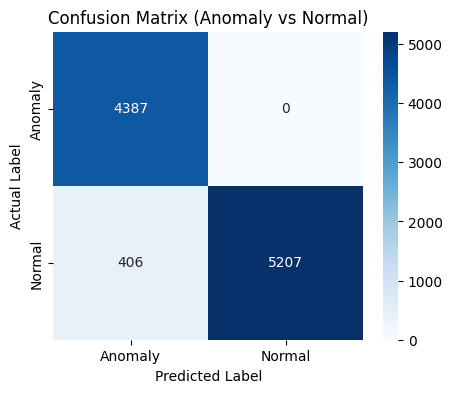

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

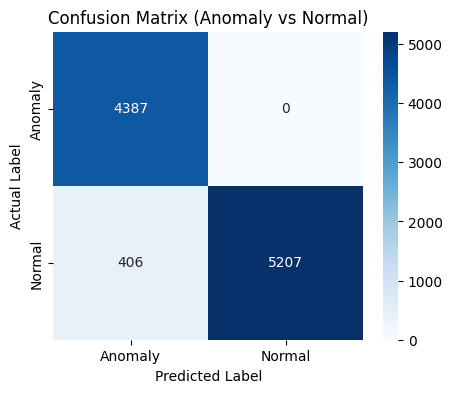

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [18]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)
acc = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.92      1.00      0.96      4387
      Normal       1.00      0.93      0.96      5613

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Precision: 0.9152931358230754
Recall: 1.0
F1 Score: 0.9557734204793028
Accuracy: 0.9594


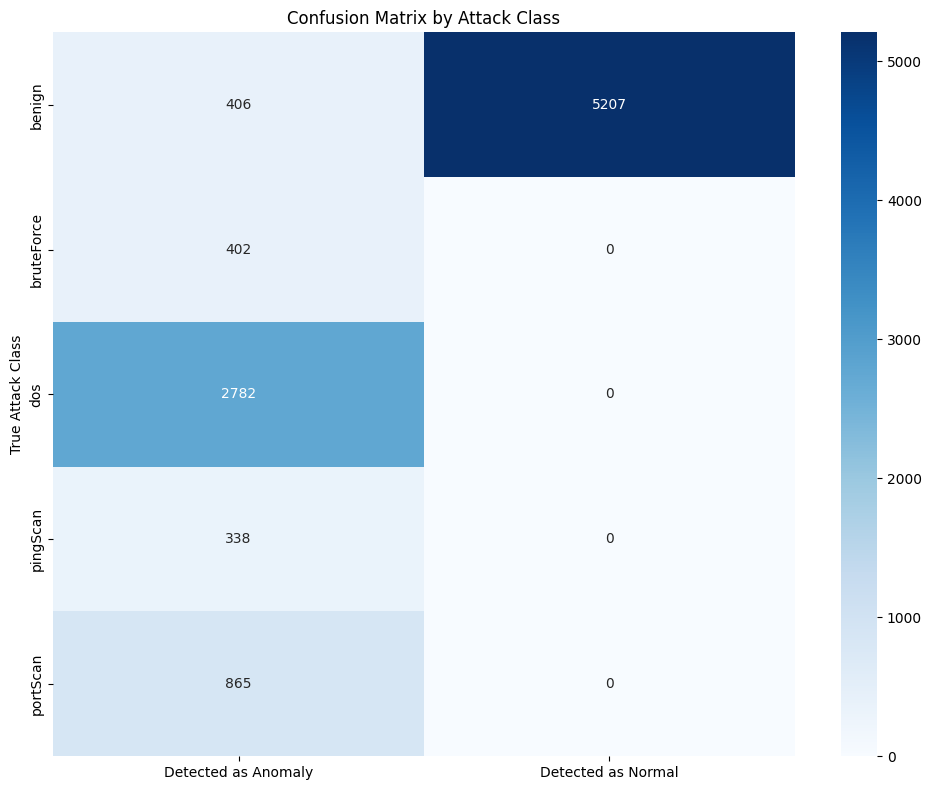

In [19]:
import numpy as np


def create_multiclass_cm(y_true_class, y_pred_binary):
    """
    Create a confusion matrix showing how each attack class was classified.

    For attack classes (DoS, Probe, R2L, U2R), correct detection is when y_pred = -1 (anomaly)
    For normal class, correct detection is when y_pred = 1 (normal)
    """
    classes = np.unique(y_true_class)
    cm = np.zeros((len(classes), 2))

    for i, cls in enumerate(classes):
        # Get predictions for this class
        cls_indices = y_true_class == cls
        preds = y_pred_binary[cls_indices]

        # Count correct and incorrect predictions
        if cls == "normal":
            cm[i, 0] = np.sum(preds == -1)  # incorrectly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # correctly detected as normal
        else:
            cm[i, 0] = np.sum(preds == -1)  # correctly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # incorrectly detected as normal

    return cm, classes


# Create and plot the multi-class confusion matrix
cm_multi, classes = create_multiclass_cm(y_test_class, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_multi,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Detected as Anomaly", "Detected as Normal"],
    yticklabels=classes,
)
plt.ylabel("True Attack Class")
plt.title("Confusion Matrix by Attack Class")
plt.tight_layout()
plt.show()

In [20]:
# Calculate detection rates for each class
print("Detection rates by class:")
class_metrics = {}
for cls in np.unique(y_test_class):
    # Get indices for this class
    class_indices = y_test_class == cls

    # True values and predictions for this class
    y_true_cls = y_test[class_indices]
    y_pred_cls = y_pred[class_indices]

    # Calculate metrics
    if cls == "Normal":
        # For normal class, we want to detect 1 (normal)
        correct = np.sum((y_pred_cls == 1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=1, zero_division=0)
    else:
        # For attack classes, we want to detect -1 (anomaly)
        correct = np.sum((y_pred_cls == -1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=-1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=-1, zero_division=0)

    total = len(y_pred_cls)
    detection_rate = correct / total
    f1 = f1_score(
        y_true_cls, y_pred_cls, pos_label=-1 if cls != "Normal" else 1, zero_division=0
    )

    class_metrics[cls] = {
        "detection_rate": detection_rate,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "count": total,
        "correctly_detected": correct,
    }

    print(f"{cls}: {detection_rate:.4f} ({correct}/{total})")

Detection rates by class:
benign: 0.0723 (406/5613)
bruteForce: 1.0000 (402/402)
dos: 1.0000 (2782/2782)
pingScan: 1.0000 (338/338)
portScan: 1.0000 (865/865)
